In [8]:
# import datacube
import numpy as np
import rioxarray as rio
import matplotlib.pyplot as plt
import pickle, os
#from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline

from dask.distributed import Client
client = Client()
client

/home/javier/miniconda3/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37815 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37815/status,
Dashboard: http://127.0.0.1:37815/status,Workers: 8
Total threads: 32,Total memory: 31.22 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42535,Workers: 8
Dashboard: http://127.0.0.1:37815/status,Total threads: 32
Started: Just now,Total memory: 31.22 GiB
Comm: tcp://127.0.0.1:33515,Total threads: 4
Dashboard: http://127.0.0.1:34439/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:44169,


In [2]:
# Load the raster data
img = rio.open_rasterio("Rasters/phenoshapeAll_masked.tif", chunks={'band': 1, 'x': 350, 'y': 350})
img

,Array,Chunk
Bytes,2.20 GiB,0.93 MiB
Shape,"(52, 2243, 2530)","(1, 350, 350)"
Count,2 Graph Layers,2912 Chunks
Type,float64,numpy.ndarray


In [16]:
# chunk the data into smaller pieces using the terminal command
# usued only for KernelPCA, as it runs out of memory
# if tmp folder does not exist, create it with python
if not os.path.exists('tmp'):
    os.makedirs('tmp')

!gdal_retile.py -ps 512 512 -targetDir tmp Rasters/phenoshapeAll_masked.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [3]:
# Convert the raster data to a 2D array and re-organize the data
data = img.stack(z=('y','x'))
data = data.transpose('z', 'band')
data 

<xarray.DataArray (z: 5674790, band: 52)>
dask.array<transpose, shape=(5674790, 52), dtype=float64, chunksize=(123970, 1), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
    spatial_ref  int64 0
  * z            (z) object MultiIndex
  * y            (z) float64 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
  * x            (z) float64 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [4]:
# delete rows with NaN values in data
data_na = data.dropna(dim='z', how='any')
data_na

<xarray.DataArray (z: 2792045, band: 52)>
dask.array<getitem, shape=(2792045, 52), dtype=float64, chunksize=(97397, 1), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
    spatial_ref  int64 0
  * z            (z) object MultiIndex
  * y            (z) float64 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
  * x            (z) float64 5.839e+05 5.84e+05 ... 5.765e+05 5.765e+05
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [5]:
# select 100,000 random rows from the data_na. Reductions for KernelPCA, which is computationally expensive and run out of memory
data_na = data_na.isel(z=np.random.choice(data_na.z.size, 1000, replace=False))
data_na

/home/javier/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]


<xarray.DataArray (z: 1000, band: 52)>
dask.array<getitem, shape=(1000, 52), dtype=float64, chunksize=(2, 1), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
    spatial_ref  int64 0
  * z            (z) object MultiIndex
  * y            (z) float64 4.228e+06 4.222e+06 ... 4.231e+06 4.226e+06
  * x            (z) float64 5.956e+05 5.818e+05 ... 5.84e+05 5.847e+05
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [5]:
# Define the number of dimensions for the reduced space
n_components = 5

In [ ]:
# fit kernelPCA
pipe = Pipeline([
        ('scale', StandardScaler()),
        #('reduce_dims', PCA(n_components=n_components)),
        ('reduce_dims', KernelPCA(n_components=n_components, kernel='rbf')),
        ])

pipe.fit(data_na)

In [7]:
# save fitted model to disk for later use
pickle.dump(pipe, open("models/pipe_kernelPCA.pkl", "wb"))

In [9]:
pca_info = pipe.named_steps['reduce_dims']
#explained_variance = pca_info.explained_variance_ratio_
explained_variance = pca_info.eigenvalues_
print(explained_variance)

# save the results to a txt file
#np.savetxt('explained_variance_PCA.txt', explained_variance, delimiter=',')
np.savetxt('explained_variance_kernelPCA.txt', explained_variance, delimiter=',')

[152.1432198  100.60622744  82.79745975  38.89576517  34.84907177]


Text(0.5, 0, 'Number of components')

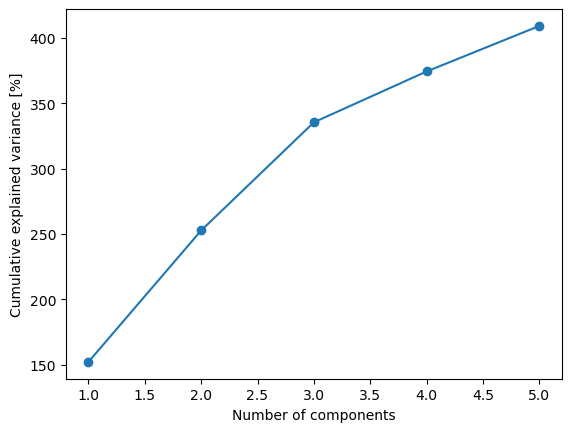

In [10]:
# plot the cumuative explained variance. X axis with intervals of 1
plt.plot(np.arange(1, n_components+1), np.cumsum(explained_variance), 'o-')
plt.ylabel('Cumulative explained variance [%]')
plt.xlabel('Number of components')
#plt.savefig('figures/PCA_cumulative_explained_variance.png', dpi=300)

In [ ]:
# transform the encoded data to a 3D array
# template with the xarray shape
template = data[:, 1:(n_components+1)]
template
# assign the encoded data to the template
output_array = template.copy(data=img.isel(band=1))
# unstack xarray to get the original shape
prediction = output_array.unstack()
prediction

In [9]:
## work arround for kernelPCA, as it runs out of memory

# temp folder in Rasters for ousputs
if not os.path.exists('Rasters/tmp'):
    os.makedirs('Rasters/tmp')


# load the model from disk
pipe = pickle.load(open("models/pipe_kernelPCA.pkl", "rb"))

# list the chunks of raster data
raster_chunks = !ls tmp/*.tif

for i in range(len(raster_chunks)):
    print(i+1, "of", len(raster_chunks))
    data = rio.open_rasterio(raster_chunks[i], chunks={'band': 1, 'x': 100, 'y': 100})
    data = data.stack(z=('y','x'))
    data = data.transpose('z', 'band')
    data.values = np.nan_to_num(data.values)
    data_reduced = pipe.transform(data)
    template = data[:, 1:(n_components+1)]
    output_array = template.copy(data=data_reduced)
    prediction = output_array.unstack()
    prediction.rio.to_raster("Rasters/tmp/PCA_" + str(i) + ".tif")

1 of 25
2 of 25
3 of 25
4 of 25
5 of 25
6 of 25
7 of 25
8 of 25
9 of 25
10 of 25
11 of 25
12 of 25
13 of 25
14 of 25
15 of 25
16 of 25
17 of 25
18 of 25
19 of 25
20 of 25
21 of 25
22 of 25
23 of 25
24 of 25
25 of 25


In [10]:
# make a list of the reduced space data and merge rasters using GDAL
!gdal_merge.py -o Rasters/KernelPCA.tif -of GTiff -co COMPRESS=LZW -co TILED=YES Rasters/tmp/PCA_*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [11]:
prediction = rio.open_rasterio("Rasters/KernelPCA.tif", chunks={'band': 1, 'x': 350, 'y': 350})

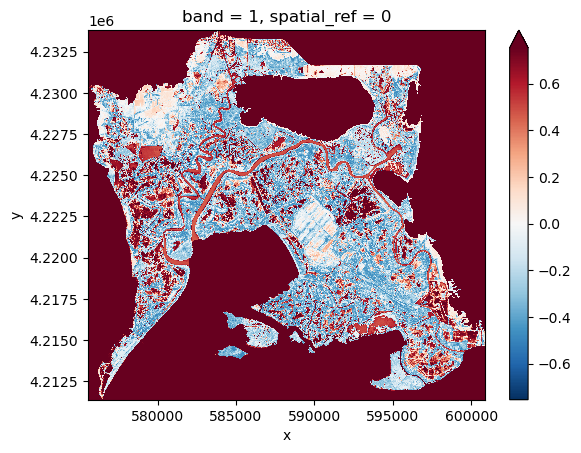

In [12]:
prediction.isel(band=0).plot(robust=True)

In [13]:
# mask out water 
import geopandas as gpd

# load shapefile to mask out the water
shp = gpd.read_file('SHP/Suisun_mask.shp')
# get the sjapefile geometry
shp_geom = shp.geometry

# mask out the water on first three bands
prediction_masked = prediction.isel(band=[0,1,2]).rio.clip(shp_geom, shp.crs, drop=False)
prediction_masked

<xarray.DataArray (band: 3, y: 2243, x: 2530)>
dask.array<where, shape=(3, 2243, 2530), dtype=float64, chunksize=(1, 350, 350), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
  * y            (y) float64 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

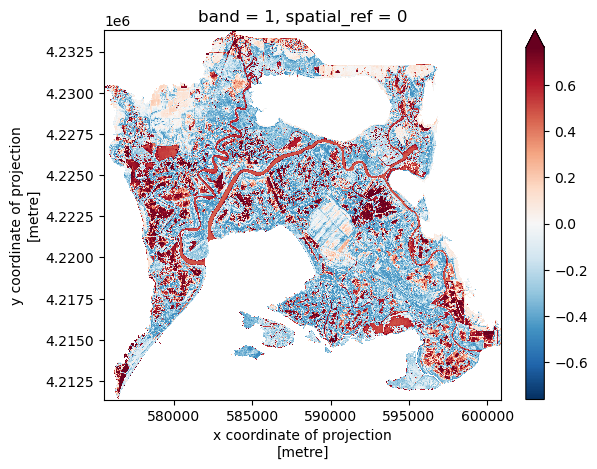

In [14]:
prediction_masked.isel(band=0).plot(robust=True)

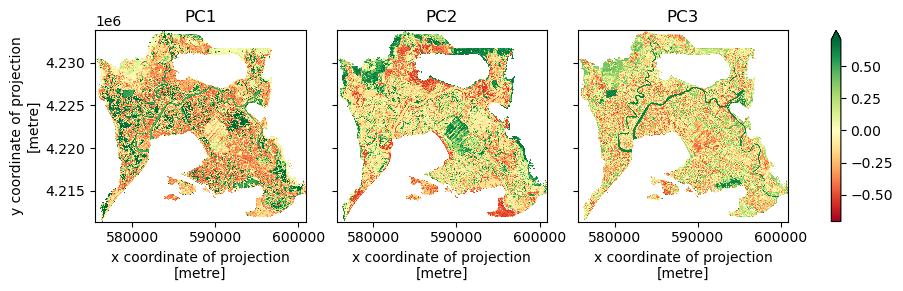

In [17]:
# RGB composition plot of the encoded data
prediction_masked.plot.imshow(col='band', col_wrap=3, cmap='RdYlGn', robust=True)
# subplot titles as PC1, PC2, PC3
for ax, title in zip(plt.gcf().axes, ['PC1', 'PC2', 'PC3']):
    ax.set_title(title)
plt.savefig('figures/KernelPCA_components.png', dpi=300)

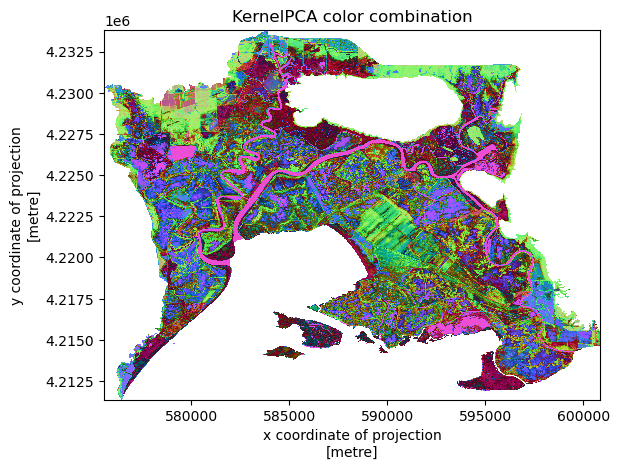

In [19]:
# RGB composition plot of the encoded data
prediction_masked[[2, 1, 0], :, :].plot.imshow(robust=True)
plt.title('KernelPCA color combination')
plt.savefig('figures/KernelPCA_color_combination.png', dpi=300)

In [20]:
# save raster to disk
prediction_masked.rio.to_raster('Rasters/KernelPCA_clip.tif')

In [22]:
# delete the temporary files
!rm -r Rasters/tmp
!rm -r tmp

In [ ]:
# rasterize shp using data as a template using gdal
#!gdal_rasterize -a id -tr 10 10 -te 0 0 1000 1000 -ot Byte -of GTiff -co COMPRESS=LZW -co TILED=YES SHP/Suisun_.shp Rasters/Suisun_mask.tif